In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
# pandasとtensorflowのインストール（必要に応じて）
!pip install pandas tensorflow scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import random as random
import os
import sys
import copy

In [4]:
#乱数の固定化

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    if "torch" in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

seed_everything(42)

In [5]:
# Compasデータセットのダウンロード
!wget https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv

# pandasでデータを読み込む
data = pd.read_csv("compas-scores-two-years.csv")

# データの最初の5行を表示して確認
print(data.head())


--2025-05-01 08:27:47--  https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546489 (2.4M) [text/plain]
Saving to: ‘compas-scores-two-years.csv’

compas-scores-two-y 100%[===================>]   2.43M  --.-KB/s    in 0.009s  

2025-05-01 08:27:47 (277 MB/s) - ‘compas-scores-two-years.csv’ saved [2546489/2546489]

   id                name   first         last compas_screening_date   sex  \
0   1    miguel hernandez  miguel    hernandez            2013-08-14  Male   
1   3         kevon dixon   kevon        dixon            2013-01-27  Male   
2   4            ed philo      ed        philo            2013-04-14  Male   
3   5         marcu brown   marcu        brown  

In [6]:
# データ（特徴量）をPandasのデータフレームに変換
df_data = data
# ターゲット（ラベル）を別に保存
target = data['two_year_recid']

#NaNを含むColumn名
nan_columns = df_data.columns[df_data.isnull().any()].tolist()
print("NaNを含む列:", nan_columns)


#欠損値がある行を削除
df_data = data.dropna()
# 不要な列を削除（例：idなど）
df_data = data.drop(columns=['id', 'first','last','start','end','event'], axis=1)
df_data = df_data.drop(nan_columns, axis=1)


df_encoded = pd.get_dummies(df_data)

# ターゲット（ラベル）をOne-Hot Encoding後のデータフレームに追加
df_encoded['target'] = target

X = df_encoded.drop(['two_year_recid','is_recid','is_violent_recid','target'], axis=1)  # 特徴量

y = df_encoded['target'] if 'target' in df_encoded.columns else df_data['target']  # 'target'が存在する場合のみ取得



NaNを含む列: ['days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date', 'c_arrest_date', 'c_days_from_compas', 'c_charge_desc', 'r_case_number', 'r_charge_degree', 'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid', 'vr_case_number', 'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc', 'in_custody', 'out_custody']


In [40]:
# 訓練セットとテストセットに分割
# (課題1)50％をテストデータとして分けた
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,test_size=0.5, random_state=42)

# 残り50%から25%を検証データにする（全体の15%）
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.50, random_state=42)

# データの標準化

scaler = StandardScaler()

# 訓練データに対して平均と標準偏差を計算し、それで変換する
X_train = scaler.fit_transform(X_train)
# 訓練データで計算した基準（平均.標準偏差）を使って検証データとテストデータも同じように整える
X_val = scaler.fit_transform(X_val)
X_test = scaler.transform(X_test)

In [41]:
# NumPy配列からPyTorchのテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # 二値分類の場合、ラベルはlong型


In [42]:
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)


X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [43]:
class CompasDataset:
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [44]:
batch_size = 128
train_dataset = CompasDataset(X_train_tensor, y_train_tensor)
val_dataset = CompasDataset(X_val_tensor, y_val_tensor)
test_dataset = CompasDataset(X_test_tensor, y_test_tensor)
# データローダーの作成
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(train_dataset)

In [45]:
class CompasDataset:
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels  # Assign labels directly instead of calling .values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx] # Access elements using indexing

In [46]:
length=len(X.columns)
print(length)

14710


In [64]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(14710, 128),
            # 活性化関数をrelu関数からsigmoid関数に変更した
            nn.Sigmoid(),
            nn.Linear(128,2)
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        a=nn.Softmax(dim=1)
        b=a(logits)
        return b


model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=14710, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [65]:
for name, param in model.named_parameters():
    print(f"{name}: mean={param.data.mean().item()}, std={param.data.std().item()}")

linear_relu_stack.0.weight: mean=4.3785394154838286e-07, std=0.0047621880657970905
linear_relu_stack.0.bias: mean=0.0011666000355035067, std=0.0047414181753993034
linear_relu_stack.2.weight: mean=0.0009070867672562599, std=0.05075123533606529
linear_relu_stack.2.bias: mean=-0.011439661495387554, std=0.016111142933368683


In [66]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In [67]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # 損失誤差を計算
        pred = model(X)
        #print(pred)
        loss = loss_fn(pred, y)

        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [68]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    avg_loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            avg_loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    avg_loss /= size
    accuracy /= size
    return avg_loss, accuracy


In [69]:
epochs = 100
patience = 5
best_val_loss = float("inf")
patience_counter = 0

In [ ]:

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    val_loss, val_accuracy = test(val_loader, model)
    print(f"Val Error: \n Accuracy: {(100*val_accuracy):>0.1f}%, Val loss: {val_loss:>8f} \n")

# 最良のモデルを保存&EarlyStopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        best_model_state = copy.deepcopy(model.state_dict())
    # 検証損失が改善しなかった回数がpatience回を超えたら学習を終了
    else:
        patience_counter += 1
    if patience_counter >= patience:
      print("Early stopping triggered!")
      break

print("Done!")

# 未知のテストデータでモデル学習、最終的な精度と損失を表示します
test_loss, test_accuracy = test(test_loader, model)
print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Val loss: {test_loss:>8f} \n")


Epoch 1
-------------------------------
loss: 0.329694  [    0/ 5051]
loss: 0.327372  [ 1280/ 5051]
loss: 0.328545  [ 2560/ 5051]
loss: 0.327886  [ 3840/ 5051]
Val Error: 
 Accuracy: 68.8%, Val loss: 0.005004 

Epoch 2
-------------------------------
loss: 0.328559  [    0/ 5051]
loss: 0.328076  [ 1280/ 5051]
loss: 0.328416  [ 2560/ 5051]
loss: 0.329243  [ 3840/ 5051]
Val Error: 
 Accuracy: 68.8%, Val loss: 0.005004 

Epoch 3
-------------------------------
loss: 0.328858  [    0/ 5051]
loss: 0.326754  [ 1280/ 5051]
loss: 0.327310  [ 2560/ 5051]
loss: 0.329002  [ 3840/ 5051]
Val Error: 
 Accuracy: 68.8%, Val loss: 0.005004 

Epoch 4
-------------------------------
loss: 0.327610  [    0/ 5051]
loss: 0.327627  [ 1280/ 5051]
loss: 0.326722  [ 2560/ 5051]
loss: 0.327334  [ 3840/ 5051]
Val Error: 
 Accuracy: 68.8%, Val loss: 0.005003 

Epoch 5
-------------------------------
loss: 0.327885  [    0/ 5051]
loss: 0.328101  [ 1280/ 5051]
loss: 0.326851  [ 2560/ 5051]
loss: 0.327391  [ 3840/ 50

In [38]:
y_pred = model(X_test_tensor.to(device)).argmax(1)

              precision    recall  f1-score   support

           0      0.632     0.934     0.754       823
           1      0.761     0.277     0.407       620

    accuracy                          0.652      1443
   macro avg      0.696     0.606     0.580      1443
weighted avg      0.687     0.652     0.605      1443



<Axes: >

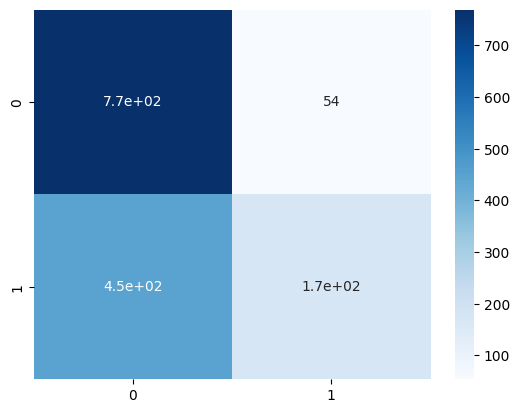

In [39]:
# テスト用データで予測値を生成する

# テスト用データで予測した結果のclassfication_reportを表示する
from sklearn.metrics import classification_report

# classfication_reportを表示
print(classification_report(y_test_tensor.cpu(),y_pred.cpu(),digits=3))

# 混同行列を作成してseabornで表示する
from sklearn.metrics import confusion_matrix
import seaborn as sns
# 混同行列を表示
cm = confusion_matrix(y_test_tensor.cpu(),y_pred.cpu())
sns.heatmap(cm, annot=True, cmap='Blues')
